In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from kymatio.torch import Scattering2D
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from collections import defaultdict
import random
import os

import matplotlib.colors as mcolors
import sys

In [ ]:
# Parameters
NUM_CHANNELS = 3
NUM_CLASSES = 7
SCATTERING_ORDER = 2
SCATTERING_COEFFS = 81  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ScatteringOutputSize = SCATTERING_COEFFS * NUM_CHANNELS
dataset_root = '/home/brus/Projects/wavelet/datasets/HPL_images/custom_dataset'
save_path = '/home/brus/Projects/wavelet/elaborations/trained_models/7_classes2.pth'
image_path = '/home/brus/Projects/wavelet/elaborations/results/DJI_0981.JPG'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 90
plots_dir = '/home/brus/Projects/wavelet/elaborations/plots'
os.makedirs(plots_dir, exist_ok=True)

In [ ]:
# Funzione per stampare un riepilogo dettagliato della configurazione
def print_configuration_summary(dataset_root, balanced_dataset, train_loader, test_loader, 
                               model, optimizer, scattering, transform, device, num_classes, num_channels):
    """
    Stampa un riepilogo dettagliato della configurazione del sistema di classificazione.
    """    
        
    train_size = len(train_loader.dataset)
    test_size = len(test_loader.dataset)
    
    # Estrae i parametri di scattering
    J = scattering.J
    max_order = scattering.max_order
    shape = scattering.shape
    
    print("\n" + "="*80)
    print(" "*30 + "RIEPILOGO CONFIGURAZIONE" + " "*30)
    print("="*80)

    # Informazioni sul dataset
    print("\n[1] DATASET:")
    print(f"  • Percorso: {dataset_root}")
    print(f"  • Numero di classi: {num_classes}")
    print(f"  • Classi rilevate: {balanced_dataset.get_class_names()}")
    print(f"  • Numero di canali: {num_channels}")
    print(f"  • Campioni totali (bilanciati): {len(balanced_dataset)}")
    print(f"  • Campioni per classe: {len(balanced_dataset) // num_classes}")
    print(f"  • Split: {train_size} training / {test_size} test ({train_size/len(balanced_dataset)*100:.1f}%/{test_size/len(balanced_dataset)*100:.1f}%)")

    # Informazioni sulle trasformazioni
    print("\n[2] TRASFORMAZIONI:")
    print(f"  • Pipeline: {transform}")

    # Informazioni sulla trasformata scattering
    print("\n[3] TRASFORMATA SCATTERING:")
    print(f"  • Parametro J: {J}")
    print(f"  • Ordine massimo: {max_order}")
    print(f"  • Forma input: {shape}")
    
    # Calcola dimensioni output scattering
    with torch.no_grad():
        # Usa il NUM_CHANNELS rilevato direttamente qui
        dummy_input = torch.zeros((1, num_channels, shape[0], shape[1])).to(device)
        scat_output = scattering(dummy_input)
        scat_shape = scat_output.shape
    
    print(f"  • Forma output: {scat_shape}")
    print(f"  • Coefficienti totali: {scat_shape[1]}")
    print(f"  • Dispositivo: {device}")

    # Informazioni sul modello
    print("\n[4] MODELLO:")
    print(f"  • Architettura: {type(model).__name__}")
    print(f"  • Dimensione input: {scat_shape[1]}")
    print(f"  • Numero classi output: {num_classes}")
    print(f"  • Parametri totali: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  • Parametri allenabili: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Informazioni sui dataloader
    print("\n[5] DATALOADER:")
    print(f"  • Batch size training: {train_loader.batch_size}")
    print(f"  • Batch size test: {test_loader.batch_size}")
    print(f"  • Training batches: {len(train_loader)}")
    print(f"  • Test batches: {len(test_loader)}")
    # Corretto: verifichiamo se l'attributo shuffle esiste prima di accedervi
    shuffle_enabled = getattr(train_loader, "shuffle", None)
    if shuffle_enabled is None:  # Se l'attributo non esiste direttamente
        shuffle_enabled = getattr(train_loader.sampler, "shuffle", False)
    print(f"  • Shuffle training: {shuffle_enabled}")
    print(f"  • Num workers: {train_loader.num_workers}")

    # Informazioni sull'ottimizzatore
    print("\n[6] OTTIMIZZATORE:")
    print(f"  • Tipo: {type(optimizer).__name__}")
    for param_group in optimizer.param_groups:
        print(f"  • Learning rate iniziale: {param_group['lr']}")
        # Gestisce il caso in cui alcuni parametri potrebbero non essere presenti
        print(f"  • Momentum: {param_group.get('momentum', 'N/A')}")
        print(f"  • Weight decay: {param_group.get('weight_decay', 'N/A')}")

    # Informazioni sul sistema
    print("\n[7] SISTEMA:")
    print(f"  • PyTorch version: {torch.__version__}")
    print(f"  • CUDA disponibile: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"  • Dispositivo CUDA: {torch.cuda.get_device_name(0)}")
        print(f"  • Memoria totale GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        print(f"  • Memoria allocata GPU: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  • CPU count: {os.cpu_count()}")

    print("\n" + "="*80)
    print(" "*25 + "CONFIGURAZIONE PRONTA PER L'ADDESTRAMENTO" + " "*25)
    print("="*80 + "\n")

# Modello per la classificazione con scattering transform
class ScatteringClassifier(nn.Module):
    def __init__(self, in_channels, classifier_type='cnn', num_classes=4):
        super(ScatteringClassifier, self).__init__()
        self.in_channels = in_channels
        self.classifier_type = classifier_type
        self.num_classes = num_classes
        self.build()

    def build(self):
        self.K = self.in_channels
        self.bn = nn.BatchNorm2d(self.K)
        
        if self.classifier_type == 'cnn':
            cfg = [256, 256, 256, 'M', 512, 512, 512, 1024, 1024]
            layers = []
            current_in_channels = self.K
            for v in cfg:
                if v == 'M':
                    layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                else:
                    layers += [
                        nn.Conv2d(current_in_channels, v, kernel_size=3, padding=1),
                        nn.BatchNorm2d(v),
                        nn.ReLU(inplace=True)
                    ]
                    current_in_channels = v
            layers += [nn.AdaptiveAvgPool2d(2)]
            self.features = nn.Sequential(*layers)
            self.classifier = nn.Linear(1024 * 4, self.num_classes)
        elif self.classifier_type == 'mlp':
            self.classifier = nn.Sequential(
                nn.Linear(self.K * 8 * 8, 1024),
                nn.ReLU(),
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Linear(1024, self.num_classes))
            self.features = None
        elif self.classifier_type == 'linear':
            self.classifier = nn.Linear(self.K * 8 * 8, self.num_classes)
            self.features = None

    def forward(self, x):
        x = self.bn(x.view(-1, self.K, 8, 8))
        if self.features:
            x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Dataset bilanciato
class BalancedDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, balance=True):
        self.root = root
        self.transform = transform
        self.samples = []
        self.classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Raccogliere le immagini per classe
        class_images = defaultdict(list)
        allowed_extensions = {'.jpg'}
        
        for cls in self.classes:
            cls_dir = os.path.join(root, cls)
            for fname in os.listdir(cls_dir):
                ext = os.path.splitext(fname)[1].lower()
                if ext in allowed_extensions:
                    filepath = os.path.join(cls_dir, fname)
                    class_images[cls].append((filepath, self.class_to_idx[cls]))
        
        # Bilanciamento opzionale (se richiesto)
        if balance:
            min_samples = min(len(images) for images in class_images.values())
            for cls, images in class_images.items():
                if len(images) > min_samples:
                    # Campionamento casuale per bilanciare
                    selected_images = random.sample(images, min_samples)
                    self.samples.extend(selected_images)
                else:
                    self.samples.extend(images)
        else:
            # Usa tutte le immagini senza bilanciamento
            for images in class_images.values():
                self.samples.extend(images)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        filepath, label = self.samples[index]
        image = Image.open(filepath).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    
# Trasformazioni per il dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Inizializzazione scattering transform
scattering = Scattering2D(
    J=2,
    shape=(32, 32),
    max_order=SCATTERING_ORDER
).to(device)

# Inizializzazione modello
model = ScatteringClassifier(ScatteringOutputSize, 'cnn', NUM_CLASSES).to(device)

# Dataset bilanciato
balanced_dataset = BalancedDataset(dataset_root, transform=transform, balance=True)
class_to_idx = balanced_dataset.class_to_idx

# Divisione train/test
train_indices, test_indices = train_test_split(
    range(len(balanced_dataset)), 
    test_size=0.2, 
    random_state=42, 
    stratify=[label for _, label in balanced_dataset.samples]
)

# Dataloader
train_dataset = torch.utils.data.Subset(balanced_dataset, train_indices)
test_dataset = torch.utils.data.Subset(balanced_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Ottimizzatore
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

print_configuration_summary(dataset_root, balanced_dataset, train_loader, test_loader,
                           model, optimizer, scattering, transform, device, NUM_CLASSES, NUM_CHANNELS)

In [ ]:
# Funzioni di training e test
def train(model, device, train_loader, optimizer, epoch, scattering):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        scattering_coeffs = scattering(data)
        scattering_coeffs = scattering_coeffs.view(data.size(0), -1, 8, 8)
        output = model(scattering_coeffs)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        if batch_idx % 50 == 0:
            print(f'Epoch {epoch}: [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}')
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, scattering):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            scattering_coeffs = scattering(data)
            scattering_coeffs = scattering_coeffs.view(data.size(0), -1, 8, 8)
            output = model(scattering_coeffs)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    return test_loss, accuracy

# Addestramento per 90 epoche
def train_loop(device, scattering, model, train_loader, test_loader, optimizer, epochs):
    # Stampa panoramica del dataset
    class_counts = defaultdict(int)
    for dataset in [train_loader.dataset, test_loader.dataset]:
        if isinstance(dataset, torch.utils.data.Subset):
            # Se è un subset, ottieni il dataset principale
            main_dataset = dataset.dataset
            if hasattr(main_dataset, 'samples'):
                for idx in dataset.indices:
                    _, label = main_dataset.samples[idx]
                    class_name = list(class_to_idx.keys())[list(class_to_idx.values()).index(label)]
                    class_counts[class_name] += 1
    
    # Stampa distribuzione classi
    print("Dataset Overview:")
    print("-" * 40)
    print("Class                    | Samples")
    print("-" * 40)
    for class_name, count in class_counts.items():
        print(f"{class_name:<25} | {count}")
    print("-" * 40)
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Testing samples: {len(test_loader.dataset)}")
    print("-" * 40)
        
    # Inizializzazione liste per memorizzare metriche
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        if epoch % 20 == 0 and epoch > 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.2
        
        # Esegui training e test, salvando i risultati
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch + 1, scattering)
        test_loss, test_accuracy = test(model, device, test_loader, scattering)
        
        # Salva i risultati per i grafici
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    
    return train_losses, train_accuracies, test_losses, test_accuracies

def save_model(model, path, class_mapping):
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_to_idx': class_mapping
    }, path)
    print(f"Modello salvato in {path}")

# Funzione per plottare le metriche di training
def plot_training_metrics(epochs, train_accuracies, test_accuracies, train_losses, test_losses, plots_dir):
    # Grafico dell'accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoche')
    plt.ylabel('Accuracy (%)')
    plt.title('Andamento Accuracy durante il Training')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plots_dir, 'accuracy_plot2.png'), dpi=300)
    plt.show()

    # Grafico della loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.title('Andamento Loss durante il Training')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plots_dir, 'loss_plot2.png'), dpi=300)
    plt.show()

    print(f"I grafici sono stati salvati nella cartella {plots_dir}")

# Training
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(device, scattering, model, train_loader, test_loader, optimizer, epochs)

# Percorso per salvare il modello
save_model(model, save_path, class_to_idx)

# Call the function
plot_training_metrics(epochs, train_accuracies, test_accuracies, train_losses, test_losses, plots_dir)

Processing 1024 tiles...
Progress: 100/1024 tiles (9.8%)
Progress: 200/1024 tiles (19.5%)
Progress: 300/1024 tiles (29.3%)
Progress: 400/1024 tiles (39.1%)
Progress: 500/1024 tiles (48.8%)
Progress: 600/1024 tiles (58.6%)
Progress: 700/1024 tiles (68.4%)
Progress: 800/1024 tiles (78.1%)
Progress: 900/1024 tiles (87.9%)
Progress: 1000/1024 tiles (97.7%)
Progress: 1024/1024 tiles (100.0%)
Classification complete.


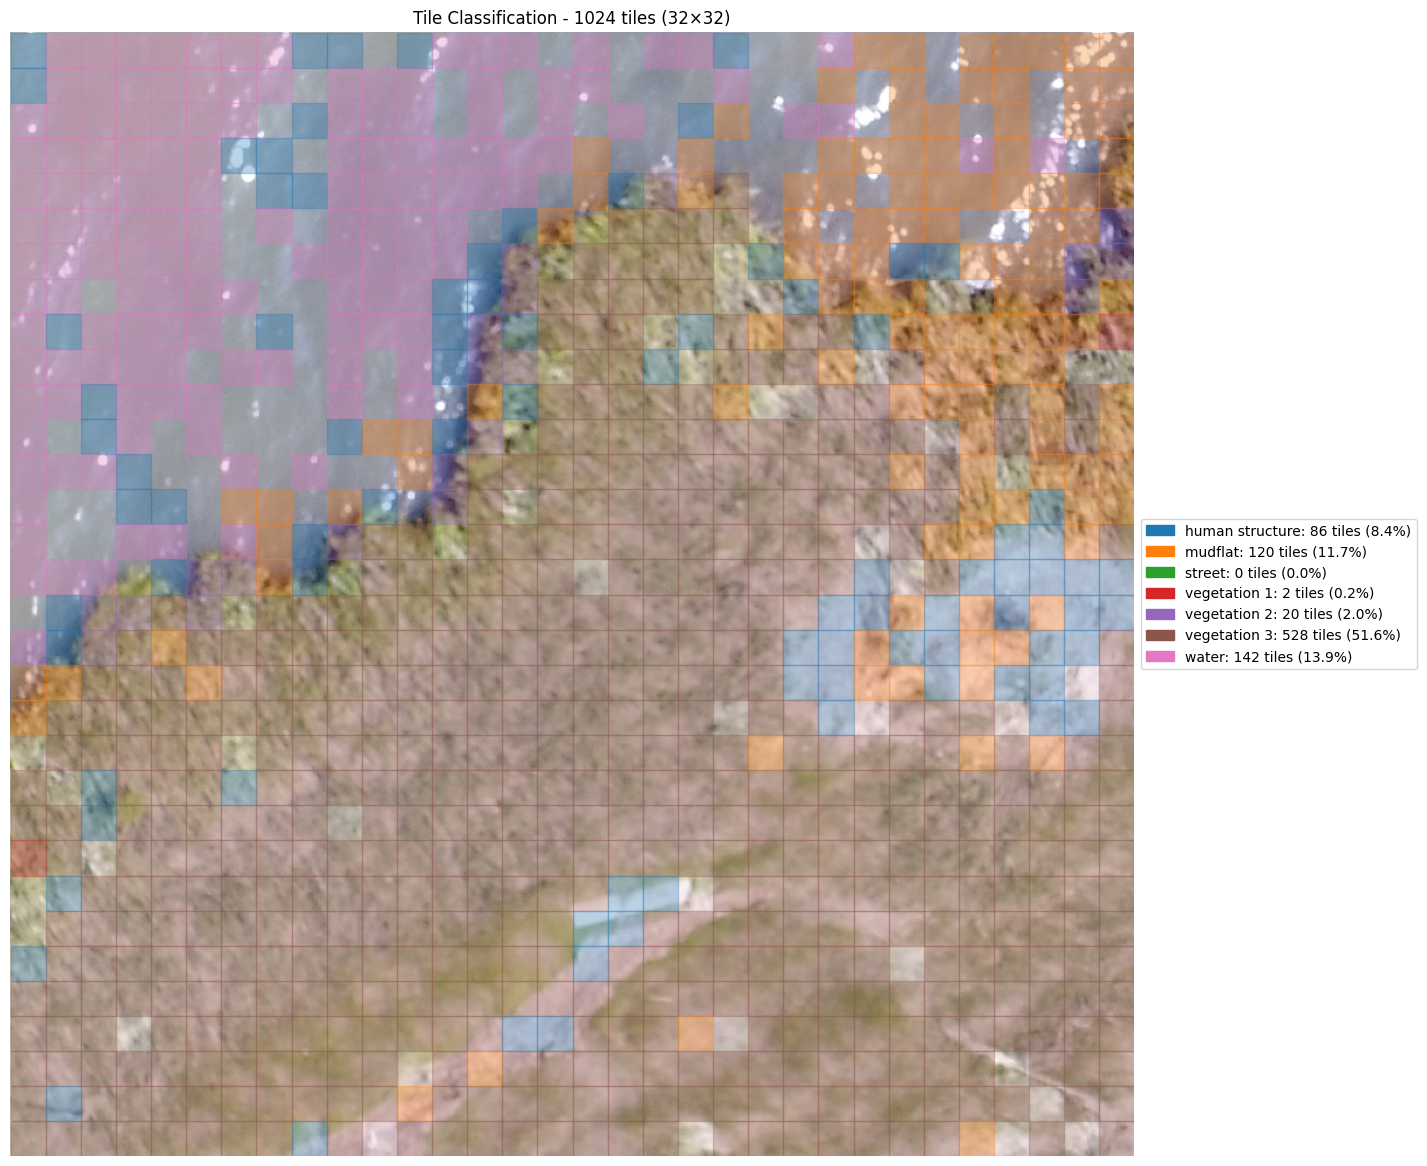

In [ ]:
def classify_image(image_path, model, scattering, device, dataset_root, 
                   class_to_idx=None, tile_size=32, process_30x30_tiles=False, 
                   confidence_threshold=0.7):
    # Determinare i nomi delle classi e il mapping
    if class_to_idx is None:
        class_names = sorted([d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))])
        class_to_idx = {cls: i for i, cls in enumerate(class_names)}
    else:
        class_names = [None] * len(class_to_idx)
        for cls, idx in class_to_idx.items():
            class_names[idx] = cls

    # Caricamento e conversione dell'immagine
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)

    # Gestione del ritaglio per immagini con tile 30x30
    if process_30x30_tiles:
        tile_size = 30
        target_size = 32
        h, w, _ = image.shape
        center_y, center_x = h // 2, w // 2
        crop_size = 30 * 32
        y_start = max(0, center_y - crop_size // 2)
        x_start = max(0, center_x - crop_size // 2)
        cropped_image = image[y_start:y_start + crop_size, x_start:x_start + crop_size, :]
        img_height, img_width, _ = cropped_image.shape
    else:
        img_height, img_width, _ = image.shape
        cropped_image = image
        target_size = tile_size

    # Calcolo del numero di tile
    num_tiles_x = img_width // tile_size
    num_tiles_y = img_height // tile_size
    
    # Matrice per le etichette e per le confidenze
    label_matrix = np.full((num_tiles_y, num_tiles_x), -1, dtype=int)
    confidence_matrix = np.zeros((num_tiles_y, num_tiles_x), dtype=float)

    # Preparazione delle trasformazioni
    transform_steps = []
    if tile_size != target_size:
        transform_steps.append(transforms.Resize((target_size, target_size)))
    transform_steps += [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
    transform = transforms.Compose(transform_steps)

    # Classificazione dei tile
    total_tiles = num_tiles_x * num_tiles_y
    print(f"Processing {total_tiles} tiles...")

    with torch.no_grad():
        processed_tiles = 0
        for i in range(num_tiles_y):
            for j in range(num_tiles_x):
                tile = cropped_image[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size, :]
                tile_img = Image.fromarray(tile)
                tile_tensor = transform(tile_img).unsqueeze(0).to(device)

                scattering_coeffs = scattering(tile_tensor)
                scattering_coeffs = scattering_coeffs.view(tile_tensor.size(0), -1, 8, 8)
                output = model(scattering_coeffs)
                
                # Calcolo softmax per ottenere le probabilità
                probabilities = torch.softmax(output, dim=1)
                max_prob, label = torch.max(probabilities, dim=1)
                
                # Memorizzazione dell'etichetta e della confidenza
                if max_prob.item() >= confidence_threshold:
                    label_matrix[i, j] = label.item()
                    confidence_matrix[i, j] = max_prob.item()

                # Aggiornamento del progresso
                processed_tiles += 1
                if processed_tiles % 100 == 0 or processed_tiles == total_tiles:
                    progress_percent = (processed_tiles / total_tiles) * 100
                    print(f"Progress: {processed_tiles}/{total_tiles} tiles ({progress_percent:.1f}%)")
                    sys.stdout.flush()

    print("Classification complete.")
    return label_matrix, confidence_matrix, cropped_image, tile_size, class_names

def visualize_classification(image, label_matrix, confidence_matrix, tile_size, class_names):
    num_classes = len(class_names)
    colors = list(mcolors.TABLEAU_COLORS.values())[:num_classes]
    
    # Conteggio delle classi
    class_counts = {}
    for class_idx, name in enumerate(class_names):
        class_counts[name] = np.sum(label_matrix == class_idx)
    total_tiles = label_matrix.size
    
    plt.figure(figsize=(15, 12))
    
    # Visualizzazione dell'immagine
    plt.imshow(image)

    # Disegno dei tile colorati
    ax = plt.gca()
    for i in range(label_matrix.shape[0]):
        for j in range(label_matrix.shape[1]):
            label = label_matrix[i, j]
            if label >= 0 and label < num_classes:
                color = colors[label]
                rect = plt.Rectangle(
                    (j * tile_size, i * tile_size),
                    tile_size, tile_size,
                    linewidth=1,
                    edgecolor=color,
                    facecolor=color,
                    alpha=0.3  # Semi-trasparente
                )
                ax.add_patch(rect)
    
    # Creazione della legenda
    legend_patches = []
    for class_idx, class_name in enumerate(class_names):
        count = class_counts[class_name]
        percentage = 100 * count / total_tiles
        patch = plt.Rectangle((0, 0), 1, 1,
                               linewidth=1,
                               edgecolor=colors[class_idx],
                               facecolor=colors[class_idx],
                               label=f"{class_name}: {count} tiles ({percentage:.1f}%)")
        legend_patches.append(patch)
    
    # Aggiunta della legenda
    plt.legend(handles=legend_patches,
               loc='center left',
               bbox_to_anchor=(1, 0.5),
               fontsize=10,
               framealpha=0.8)
    
    plt.title(f'Tile Classification - {total_tiles} tiles ({label_matrix.shape[0]}×{label_matrix.shape[1]})')
    plt.tight_layout()
    plt.axis('off')
    plt.show()

# Soglia di confidenza (default 0.7)
label_matrix, confidence_matrix, cropped_image, tile_size, class_names = classify_image(
    image_path, 
    model, 
    scattering, 
    device, 
    dataset_root, 
    process_30x30_tiles=True,
    confidence_threshold=0.7 
)

visualize_classification(
    cropped_image, 
    label_matrix, 
    confidence_matrix, 
    tile_size, 
    class_names
)